# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22 
### Date Last Modified: 2024-04-22

In [1]:
!nvidia-smi

Mon Apr 22 22:38:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   66C    P8               9W /  60W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [6]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


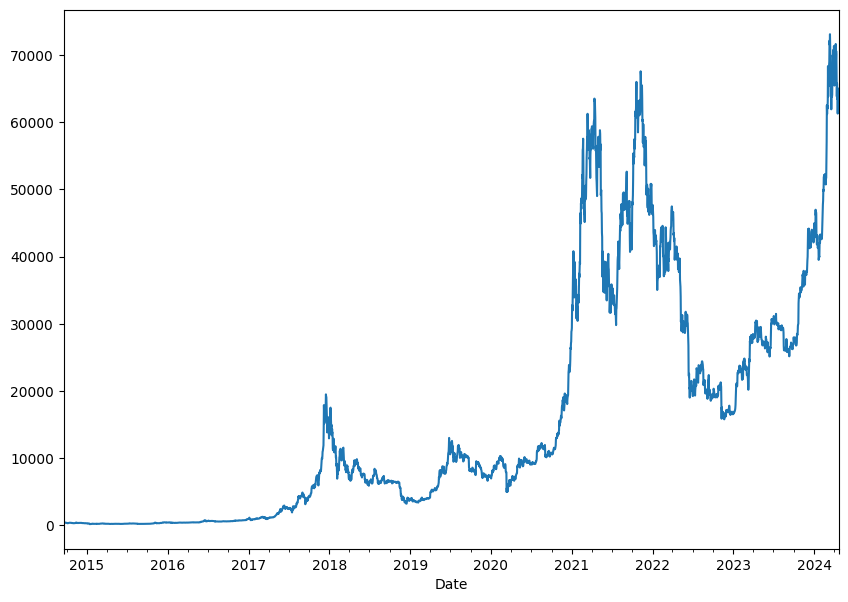

In [8]:
dataframe['Close'].plot(figsize=(10, 7));

In [9]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [10]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 63843.570313,
       64994.441406, 64773.386719])

In [11]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.87326138],
       [0.88904719],
       [0.88601512]])

In [12]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """ 
    Plots a series of timestamps against values.
    
    Parameters
    ----------
    timestamps : list 
        list of timestamp values
    values : list 
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


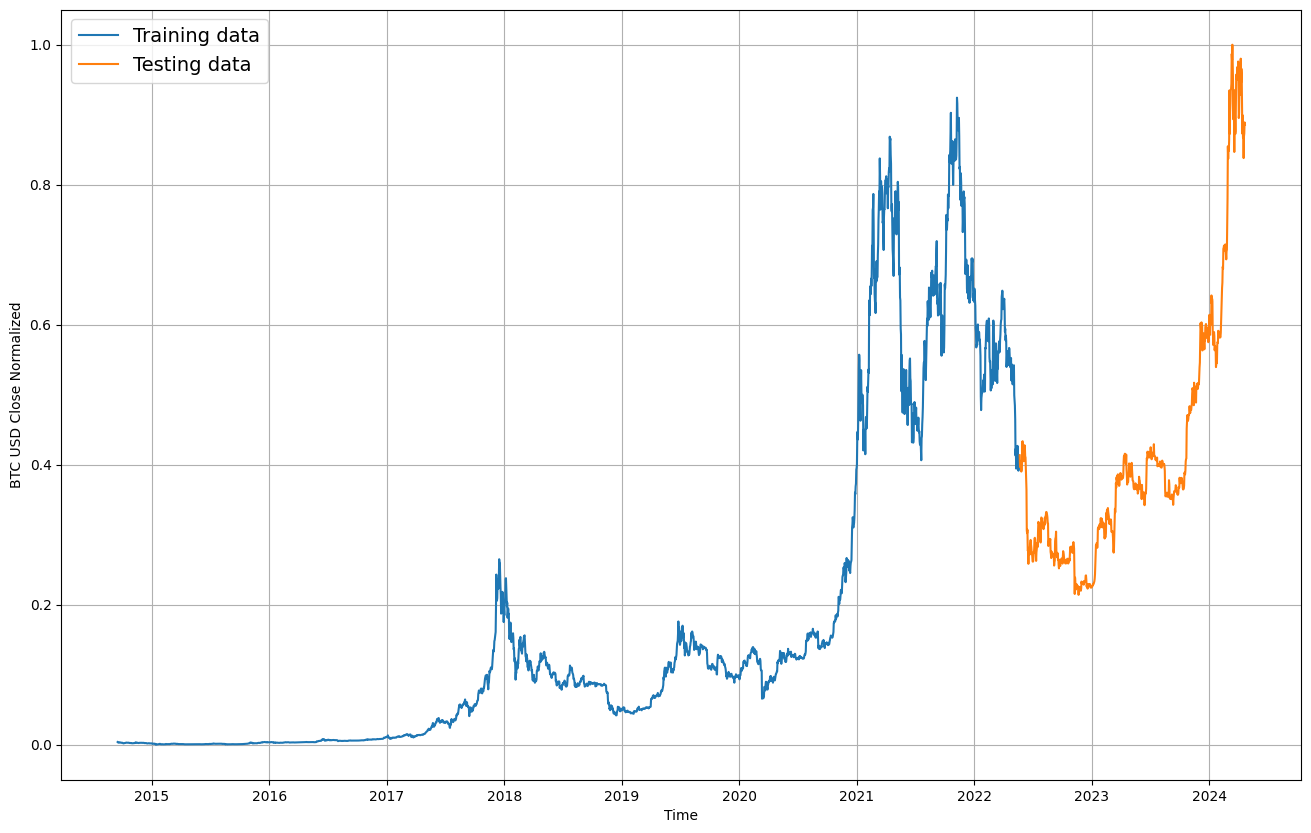

In [13]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len

plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len],
                 title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data",
                 yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [14]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values
        
    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [15]:
WINDOW_SIZE = 7
HORIZON = 1

In [16]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [17]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g. 
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8),
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [18]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

## Prepare Utilities for Training

In [19]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

Each model will be trained and validated on the following window sizes and horizons:
- Window Size: 7, Horizon: 1
- Window Size: 7, Horizon: 7
- Window Size: 30, Horizon: 1
- Window Size: 30, Horizon: 7
- Window Size: 90, Horizon: 1
- Window Size: 90, Horizon: 7
- Window Size: 90, Horizon: 30

In [20]:
def fit_eval(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100
) -> Tuple[List, Dict]:
    """
    Creates sliding windows for the given `WINDOW_SIZE` and `HORIZON`. 
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.
    
    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """
    
    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows(
            prices_normal,
            window_size=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(train_windows,
                              train_labels,
                              epochs=epochs,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[
                            create_model_checkpoint(
                                model_name=model_clone.name + "W" + str(window) + "H" + str(horizon)),
                            create_early_stopping(patience=8)
                        ])

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)
    
    return model_preds_inv, model_res


In [21]:
def save_model_plot(model: tf.keras.Model):
    """
    Saves the TF Model and a plot of the model to the filesystem.
    :param model: 
    :return: 
    """
    tf.keras.saving.save_model(model, os.path.join("model_experiments", model.name))
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        to_file=os.path.join("model_experiments", model.name + ".png")
    )
    print(f"Model saved to: {os.path.join('model_experiments', model.name, '')}")
    print(f"Model plot saved to: {os.path.join('model_experiments', model.name + '.png')}")

### FNN (Feed-forward, Densely Connected Network)

In [22]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
], name="FNN")

#### FNN - Window Size 7, Horizon 1

Epoch 1/100


I0000 00:00:1713805722.458716  111274 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 2s 26ms/step - loss: 0.0575 - mae: 0.0575 - mse: 0.0160 - mape: 3884.9929 - val_loss: 0.0175 - val_mae: 0.0175 - val_mse: 7.4475e-04 - val_mape: 4.0420
Epoch 2/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0110 - mae: 0.0110 - mse: 4.1848e-04 - mape: 3126.7773 - val_loss: 0.0134 - val_mae: 0.0134 - val_mse: 4.1272e-04 - val_mape: 3.2569
Epoch 3/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0083 - mae: 0.0083 - mse: 2.8430e-04 - mape: 756.5511 - val_loss: 0.0128 - val_mae: 0.0128 - val_mse: 3.8158e-04 - val_mape: 3.1075
Epoch 4/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0076 - mae: 0.0076 - mse: 2.4691e-04 - mape: 154.9469 - val_loss: 0.0117 - val_mae: 0.0117 - val_mse: 3.3849e-04 - val_mape: 2.7308
Epoch 5/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0066 - mae: 0.0066 - mse: 1.9077e-04 - mape: 763.3846 - val_loss: 0.0112 - val_mae: 0.0112 - val_mse: 2.95

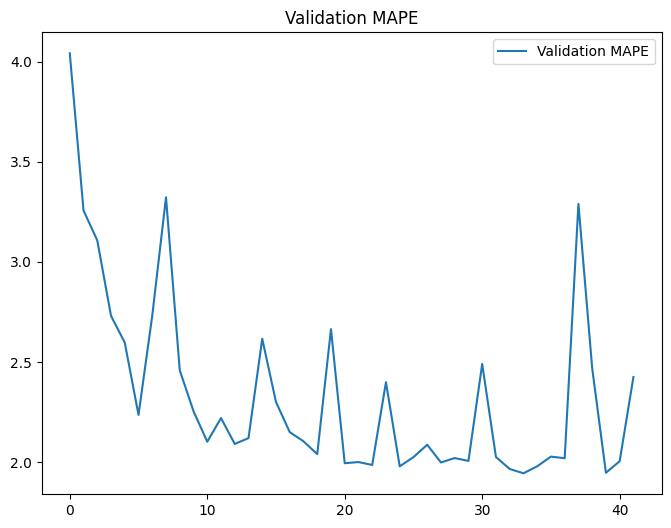

In [23]:
model_fnn_w7h1_preds_inv, model_fnn_w7h1_res = fit_eval(model_fnn, horizon=1, window=7, epochs=100)

In [24]:
model_fnn_w7h1_res

{'mae': 604.961, 'mse': 1024253.8, 'rmse': 604.961, 'mape': 1.9315499}

#### FNN - Window Size 7, Horizon 7

Epoch 1/100
22/22 [==============================] - 1s 24ms/step - loss: 0.1282 - mae: 0.1282 - mse: 0.0608 - mape: 4224.4858 - val_loss: 0.2257 - val_mae: 0.2257 - val_mse: 0.0959 - val_mape: 53.5095
Epoch 2/100
22/22 [==============================] - 0s 21ms/step - loss: 0.0737 - mae: 0.0737 - mse: 0.0265 - mape: 7214.4790 - val_loss: 0.1315 - val_mae: 0.1315 - val_mse: 0.0381 - val_mape: 30.1839
Epoch 3/100
22/22 [==============================] - 0s 21ms/step - loss: 0.0332 - mae: 0.0332 - mse: 0.0067 - mape: 3594.3186 - val_loss: 0.0318 - val_mae: 0.0318 - val_mse: 0.0023 - val_mape: 7.5510
Epoch 4/100
22/22 [==============================] - 0s 19ms/step - loss: 0.0146 - mae: 0.0146 - mse: 8.0281e-04 - mape: 1896.8958 - val_loss: 0.0225 - val_mae: 0.0225 - val_mse: 0.0012 - val_mape: 5.2942
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0129 - mae: 0.0129 - mse: 6.9434e-04 - mape: 643.7056 - val_loss: 0.0213 - val_mae: 0.0213 - val_mse: 0.0011 - val

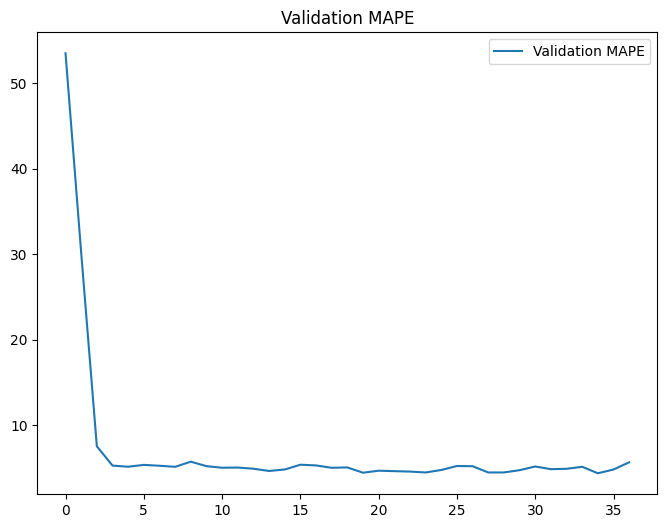

In [25]:
model_fnn_w7h7_preds_inv, model_fnn_w7h7_res = fit_eval(model_fnn, horizon=7, window=7, epochs=100)

In [26]:
model_fnn_w7h7_res

{'mae': 1362.107, 'mse': 4525144.5, 'rmse': 1362.107, 'mape': 4.461355}

#### FNN - Window Size 30, Horizon 1

Epoch 1/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0538 - mae: 0.0538 - mse: 0.0137 - mape: 7678.5913 - val_loss: 0.0385 - val_mae: 0.0385 - val_mse: 0.0027 - val_mape: 8.8961
Epoch 2/100
22/22 [==============================] - 0s 20ms/step - loss: 0.0166 - mae: 0.0166 - mse: 0.0010 - mape: 1591.6329 - val_loss: 0.0231 - val_mae: 0.0231 - val_mse: 0.0011 - val_mape: 5.8087
Epoch 3/100
22/22 [==============================] - 0s 19ms/step - loss: 0.0134 - mae: 0.0134 - mse: 7.6171e-04 - mape: 508.5649 - val_loss: 0.0209 - val_mae: 0.0209 - val_mse: 9.4944e-04 - val_mape: 4.9791
Epoch 4/100
22/22 [==============================] - 0s 19ms/step - loss: 0.0117 - mae: 0.0117 - mse: 5.7882e-04 - mape: 1000.1042 - val_loss: 0.0180 - val_mae: 0.0180 - val_mse: 6.8870e-04 - val_mape: 4.3413
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0105 - mae: 0.0105 - mse: 4.7848e-04 - mape: 307.4106 - val_loss: 0.0187 - val_mae: 0.0187 - val_mse: 7.16

{'mae': 691.02936, 'mse': 1182215.5, 'rmse': 691.02936, 'mape': 2.2323575}

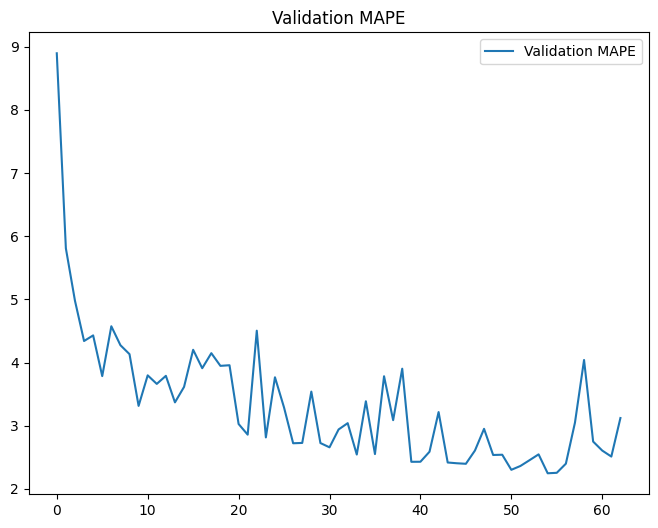

In [27]:
model_fnn_w30h1_preds_inv, model_fnn_w30h1_res = fit_eval(model_fnn, horizon=1, window=30, epochs=100)
model_fnn_w30h1_res

#### FNN - Window Size 30, Horizon 7

Epoch 1/100
22/22 [==============================] - 1s 26ms/step - loss: 0.1249 - mae: 0.1249 - mse: 0.0621 - mape: 6919.7397 - val_loss: 0.1692 - val_mae: 0.1692 - val_mse: 0.0716 - val_mape: 40.3073
Epoch 2/100
22/22 [==============================] - 0s 19ms/step - loss: 0.0498 - mae: 0.0498 - mse: 0.0131 - mape: 5452.7749 - val_loss: 0.0433 - val_mae: 0.0433 - val_mse: 0.0041 - val_mape: 10.3518
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0221 - mae: 0.0221 - mse: 0.0015 - mape: 4160.1011 - val_loss: 0.0325 - val_mae: 0.0325 - val_mse: 0.0025 - val_mape: 7.5169
Epoch 4/100
22/22 [==============================] - 0s 19ms/step - loss: 0.0175 - mae: 0.0175 - mse: 0.0012 - mape: 1277.8309 - val_loss: 0.0295 - val_mae: 0.0295 - val_mse: 0.0019 - val_mape: 7.0868
Epoch 5/100
22/22 [==============================] - 0s 21ms/step - loss: 0.0156 - mae: 0.0156 - mse: 9.8765e-04 - mape: 927.8842 - val_loss: 0.0256 - val_mae: 0.0256 - val_mse: 0.0015 - val_map

{'mae': 1322.3416, 'mse': 4320444.5, 'rmse': 1322.3416, 'mape': 4.2722178}

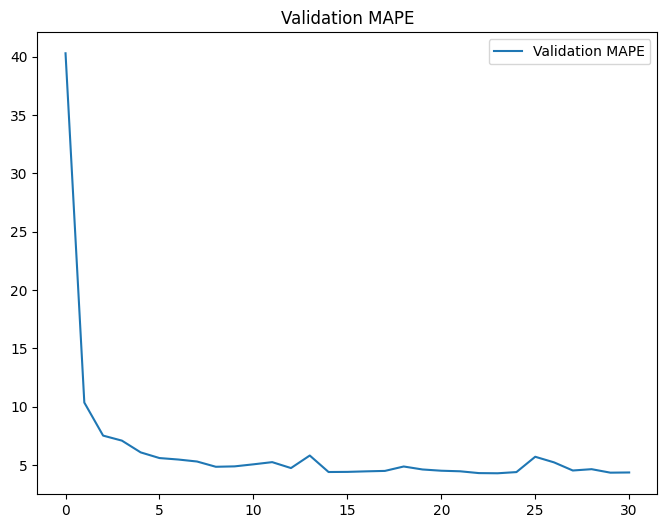

In [28]:
model_fnn_w30h7_preds_inv, model_fnn_w30h7_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w30h7_res

#### FNN - Window Size 90, Horizon 1

Epoch 1/100
22/22 [==============================] - 1s 22ms/step - loss: 0.1228 - mae: 0.1228 - mse: 0.0519 - mape: 6204.4985 - val_loss: 0.1805 - val_mae: 0.1805 - val_mse: 0.0564 - val_mape: 42.4329
Epoch 2/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0555 - mae: 0.0555 - mse: 0.0125 - mape: 8205.5059 - val_loss: 0.0776 - val_mae: 0.0776 - val_mse: 0.0127 - val_mape: 18.0369
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0298 - mae: 0.0298 - mse: 0.0033 - mape: 4307.9131 - val_loss: 0.0362 - val_mae: 0.0362 - val_mse: 0.0028 - val_mape: 8.5893
Epoch 4/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0185 - mae: 0.0185 - mse: 0.0013 - mape: 2453.6558 - val_loss: 0.0265 - val_mae: 0.0265 - val_mse: 0.0016 - val_mape: 6.3097
Epoch 5/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0153 - mae: 0.0153 - mse: 9.8690e-04 - mape: 948.2973 - val_loss: 0.0234 - val_mae: 0.0234 - val_mse: 0.0013 - val_map

{'mae': 1249.0948, 'mse': 3948743.5, 'rmse': 1249.0948, 'mape': 4.05579}

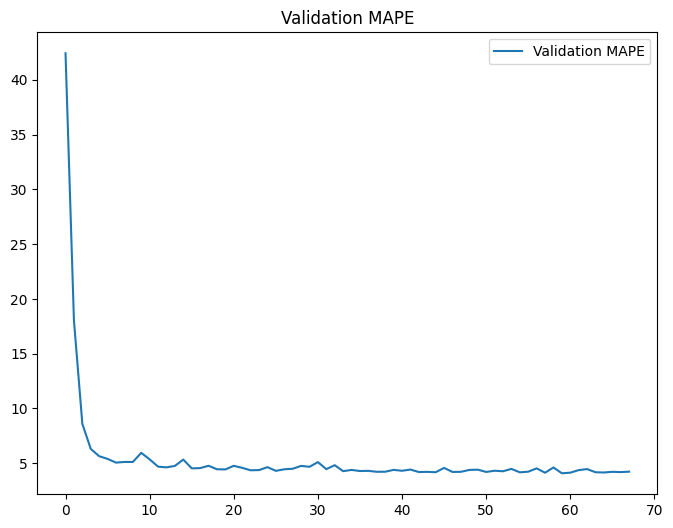

In [29]:
model_fnn_w90h1_preds_inv, model_fnn_w90h1_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w90h1_res

#### FNN - Window Size 90, Horizon 7

Epoch 1/100
22/22 [==============================] - 1s 23ms/step - loss: 0.1162 - mae: 0.1162 - mse: 0.0519 - mape: 4045.1074 - val_loss: 0.1433 - val_mae: 0.1433 - val_mse: 0.0520 - val_mape: 32.6568
Epoch 2/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0372 - mae: 0.0372 - mse: 0.0086 - mape: 4494.2793 - val_loss: 0.0329 - val_mae: 0.0329 - val_mse: 0.0024 - val_mape: 7.9779
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0204 - mae: 0.0204 - mse: 0.0015 - mape: 1901.6908 - val_loss: 0.0308 - val_mae: 0.0308 - val_mse: 0.0020 - val_mape: 7.5343
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0182 - mae: 0.0182 - mse: 0.0013 - mape: 1046.9625 - val_loss: 0.0324 - val_mae: 0.0324 - val_mse: 0.0023 - val_mape: 7.4246
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0163 - mae: 0.0163 - mse: 0.0011 - mape: 793.6345 - val_loss: 0.0270 - val_mae: 0.0270 - val_mse: 0.0016 - val_mape: 6.3

{'mae': 1290.7352, 'mse': 4273903.0, 'rmse': 1290.7352, 'mape': 4.1500263}

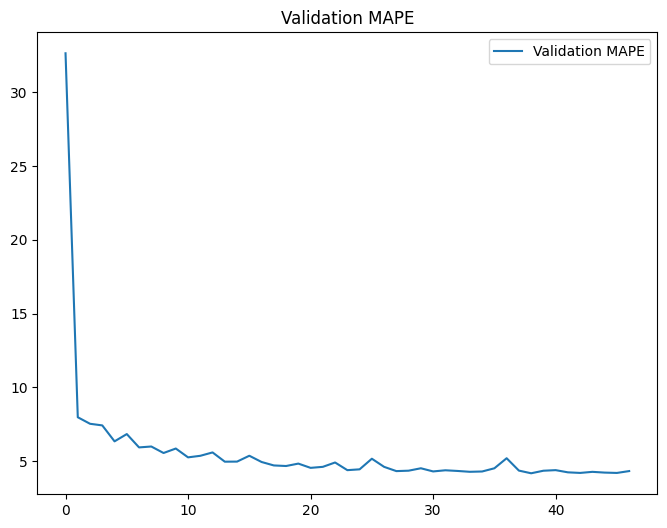

In [30]:
model_fnn_w90h7_preds_inv, model_fnn_w90h7_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w90h7_res

#### FNN - Window Size 90, Horizon 30

Epoch 1/100
22/22 [==============================] - 1s 29ms/step - loss: 0.1126 - mae: 0.1126 - mse: 0.0470 - mape: 10240.8955 - val_loss: 0.1116 - val_mae: 0.1116 - val_mse: 0.0351 - val_mape: 25.8658
Epoch 2/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0360 - mae: 0.0360 - mse: 0.0057 - mape: 5855.0430 - val_loss: 0.0375 - val_mae: 0.0375 - val_mse: 0.0027 - val_mape: 9.5408
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0218 - mae: 0.0218 - mse: 0.0017 - mape: 2428.9446 - val_loss: 0.0352 - val_mae: 0.0352 - val_mse: 0.0029 - val_mape: 7.9416
Epoch 4/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0190 - mae: 0.0190 - mse: 0.0015 - mape: 869.4010 - val_loss: 0.0304 - val_mae: 0.0304 - val_mse: 0.0022 - val_mape: 7.1140
Epoch 5/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0174 - mae: 0.0174 - mse: 0.0012 - mape: 555.3177 - val_loss: 0.0282 - val_mae: 0.0282 - val_mse: 0.0019 - val_mape: 6.

{'mae': 1331.8398, 'mse': 4259368.5, 'rmse': 1331.8398, 'mape': 4.3645597}

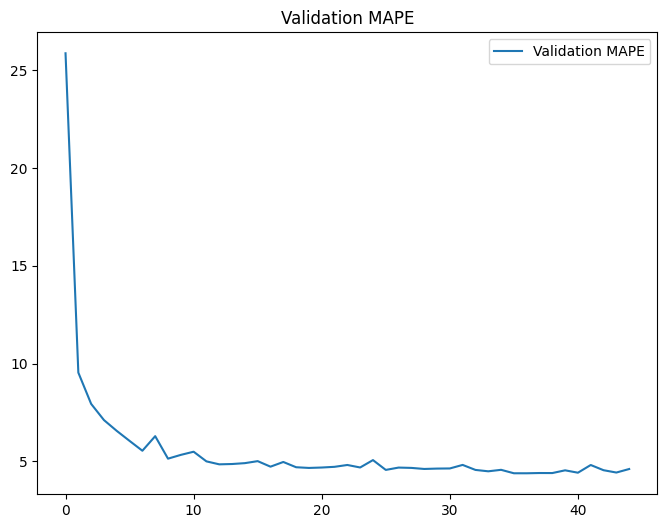

In [31]:
model_fnn_w90h30_preds_inv, model_fnn_w90h30_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w90h30_res